In [1]:
# Load 30 turn game square frequency
dat1 = readRDS("freqhist.RData")
full_hist = dat1[[1]]
full_hist_avg = full_hist/100000

# Load first lap square frequency
dat2 = read.table("firstlap_hist.txt")
firstlap_hist = unlist(dat2[2])
names(firstlap_hist) = as.numeric(unlist(dat2[1]))
firstlap_hist = as.table(firstlap_hist)
firstlap_hist_avg = firstlap_hist/100000

# Load frequency versus turn over 30 turns
dat3 = read.table("deprec.txt")
deprec = dat3
colnames(deprec) = "Depreciation"

In [2]:
#> Store monopoly board 
board1 = 1:40
board2 = c(
    "Go","Mediterranean Avenue","Community Chest","Baltic Avenue","Income Tax",
    "Reading Railroad", "Oriental Avenue", "Chance", "Vermont Avenue",
    "Connecticut Avenue", "Jail","St. Charles Place","Electric Company",
    "States Avenue","Virginia Avenue","Pennsylvania Railroad","St. James Place",
    "Community Chest","Tennessee Avenue","New York Avenue","Free Parking",
    "Kentucky Avenue","Chance","Indiana Avenue","Illinois Avenue",
    "B. & O. Railroad","Atlantic Avenue","Ventnor Avenue", "Water Works",
    "Marvin Gardens","Go To Jail","Pacific Avenue","North Carolina Avenue",
    "Community Chest","Pennsylvania Avenue", "Short Line", "Chance",
    "Park Place","Luxury Tax","Boardwalk"
)
board3 = c(
    "go","brown","community","brown","tax","railroad","lightblue","chance",
    rep("lightblue",2),"jail","pink","utility",rep("pink",2),"railroad",
    "orange","community",rep("orange",2),"parking","red","chance",rep("red",2),
    "railroad",rep("yellow",2),"utility","yellow","gotojail",rep("green",2),
    "community","green","railroad","chance","blue","tax","blue"
)

board = matrix(c(board1,board2,board3),ncol=3)
#<

#> store chance, community cards
chance_cards = c(
    "Advance to Boardwalk",
    "Advance to Go (Collect $200)",
    "Advance to Illinois Avenue. If you pass go, collect $200",
    "Advance to St. Charles Place. If you pass Go, collect $200",
    
    rep("Advance to the nearest Railroad. If unowned, you may buy it from the Bank. 
    If owned, pay wonder twice the rental to which they are otherwise entitled",2),
    
    "Advance token to nearest Utility. If unowned, you may but it from the Bank. 
    If owned, throw dice and pay owner a total of ten times amount thrown",
    
    "Bank pays you dividend of $50",
    "Get Out of Jail Free",
    "Go Back 3 Spaces",
    "Go to Jail. Go directly to Jail, do not pass Go, do not collect $200",
    
    "Make general repairs on all your property. For each house pay $25. 
    For each hotel pay $100",
    
    "Speeding fine $15",
    "Take a trip to Reading Railroad. If you pass Go, collect $200",
    
    "You have been elected Chairman of the Board. Pay each player $50",
    "Your building loan matures. Collect $150"
)

community_cards = c(
    "Advance to Go(Collect $200)",
    "Bank error in your favor. Collect $200",
    "Doctor's fee. Pay $50",
    "From sale of stock you get $50",
    "Get Out of Jail Free",
    "Go to Jail. Go directly to jail, do not pass Go, do not collect $200",
    "Holiday fund matures. Receive $100",
    "Income tax refund. Collect $100",
    "It is your birthday. Collect $10 from every player",
    "Life insurance matures. Collect $100",
    "Pay hospital fees of $100",
    "Pay school fees of $50",
    "Receive $25 consultancy fee",
    "You are assessed for street repair. $40 per house. $115 per hotel",
    "You have won second prize in a beauty context Collect $10",
    "You inherit $100"
)
#<

#> store locations
sqrailroads = as.integer(c(6,16,26,36))
squtilities = as.integer(c(13,29))
sqchance = as.integer(c(8,23,37))
sqcommunity = as.integer(c(3,18,34))
sqtax = as.integer(c(5,39))
#<

#> Create player, board, property classes
setClass("player",
         slots=list(
             piece="character",
             money ="integer",
             jail="integer",
             goj="integer",
             history.roll="integer",
             history.square="integer",
             history.lap="integer",
             history.cards="character",
             history.turns="integer"
         )
)

setClass("board",
         slots=list(
             count.players="integer",
             cards.chance="integer",
             cards.community="integer",
             updates.chance="integer",
             updates.community="integer",
             properties="data.frame"
         )
)

setClass("property",
         slots=list(
             set.color="character",
             set.squares="integer",
             set.deeds="character",
             set.means="numeric",
             set.flap_means="numeric",
             deprec="numeric",
             costs="matrix",
             rent="matrix"
         )
)
#<

#> Functions to create instances of player,board classes
new_player = function(pawn){
    p = new(
        "player",
        piece=pawn,
        money=1500L,
        jail=0L,
        goj = 0L,
        history.roll=as.integer(c(0,0)),
        history.square=as.integer(c(1)),
        history.lap = as.integer(c()),
        history.cards=as.character(c()),
        history.turns=as.integer(c(1))
    )
    
    return(p)
}
new_board = function(){
    b = new(
        "board",
        count.players = 1L,
        cards.chance = sample(1:16,16),
        cards.community = sample(1:16,16),
        updates.chance=0L,
        updates.community=0L,
        properties=data.frame(
            square=as.integer(board1),
            square_name=board2,
            square_type=board3,
            owner=rep("empty",40),
            stage=rep(0L,40),
            set=rep(0L,40),
            houses=rep(0L,40),
            hotels=rep(0L,40),
            rent=as.integer(c(200,rep(0,3),-200,rep(0,33),-100,0L)),
            dev=rep(0L,40)
        )
    )
    
    return(b)
}
#<

#> Create instances of property classes for color sets, railroads
brown_set = new(
    "property",
    set.color="brown",
    set.squares=as.integer(c(2,4)),
    set.deeds=c("Mediterranean Avenue","Baltic Avenue"),
    set.means=as.numeric(full_hist_avg[c(2,4)]),
    set.flap_means=as.numeric(firstlap_hist_avg["4"]),
    deprec=deprec[[1]][c(2,4)],
    costs=matrix(as.integer(c(60,60,120,220,320,420,520,620)),ncol=1,byrow=TRUE),
    rent=matrix(as.integer(c(2,0,0,4,4,8,10,20,30,60,90,180,160,320,250,450)),ncol=2,byrow=TRUE)
)

lightblue_set = new(
    "property",
    set.color="lightblue",
    set.squares=as.integer(c(7,9,10)),
    set.deeds=c("Oriental Avenue","Vermont Avenue","Connecticut"),
    set.means=as.numeric(full_hist_avg[c(7,9,10)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(7,9,10))]),
    deprec=deprec[[1]][c(7,9,10)],
    costs=matrix(as.integer(c(100,100,120,200,220,220,320,470,620,770,920,1070)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                6,0,0,0,6,0,0,0,8,6,6,0,6,0,8,0,6,8,12,12,16,30,30,40,90,90,100,270,270,300,
              400,400,450,550,550,600
             )
        ),
        ncol=3,byrow=TRUE
    )
)

pink_set = new(
    "property",
    set.color="pink",
    set.squares=as.integer(c(12,14,15)),
    set.deeds=c("St. Charles Place","States Avenue","Virginia Avenue"),
    set.means=as.numeric(full_hist_avg[c(12,14,15)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(12,14,15))]),
    deprec=deprec[[1]][c(12,14,15)],
    costs=matrix(as.integer(c(140,140,160,280,300,300,440,740,1040,1340,1640,1940)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                10,0,0,0,10,0,0,0,12,10,10,0,10,0,12,0,10,12,20,20,24,50,50,60,150,150,180,450,450,500,
                625,625,700,750,750,900
             )
        ),
        ncol=3,byrow=TRUE
    )
)

orange_set = new(
    "property",
    set.color="orange",
    set.squares=as.integer(c(17,19,20)),
    set.deeds=c("St. James Place","Tennessee Avenue","New York Avenue"),
    set.means=as.numeric(full_hist_avg[c(17,19,20)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(17,19,20))]),
    deprec=deprec[[1]][c(17,19,20)],
    costs=matrix(as.integer(c(180,180,200,360,380,380,560,860,1160,1460,1760,2060)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                14,0,0,0,14,0,0,0,16,14,14,0,14,0,16,0,14,16,28,28,32,70,70,80,200,200,220,550,550,600,
                750,750,800,950,950,1000
             )
        ),
        ncol=3,byrow=TRUE
    )
)

red_set = new(
    "property",
    set.color="red",
    set.squares=as.integer(c(22,24,25)),
    set.deeds=c("Kentucky Avenue","Indiana Avenue","Illinois Avenue"),
    set.means=as.numeric(full_hist_avg[c(22,24,25)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(22,24,25))]),
    deprec=deprec[[1]][c(22,24,25)],
    costs=matrix(as.integer(c(220,220,240,440,460,460,680,1130,1580,2030,2480,2930)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                18,0,0,0,18,0,0,0,20,18,18,0,18,0,20,0,18,20,36,36,40,90,90,100,250,250,300,700,700,750,
                875,875,925,1050,1050,1100
             )
        ),
        ncol=3,byrow=TRUE
    )
)

yellow_set = new(
    "property",
    set.color="yellow",
    set.squares=as.integer(c(27,28,30)),
    set.deeds=c("Atlantic Avenue","Ventnor Avenue","Marvin Gardens"),
    set.means=as.numeric(full_hist_avg[c(27,28,30)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(27,28,30))]),
    deprec=deprec[[1]][c(27,28,30)],
    costs=matrix(as.integer(c(260,260,280,800,520,540,540,1250,1700,2150,2600,3050)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                22,0,0,0,22,0,0,0,24,22,22,0,22,0,24,0,22,24,44,44,48,110,110,120,330,330,360,800,800,850,
                975,975,1025,1150,1150,1200
             )
        ),
        ncol=3,byrow=TRUE
    )
)

green_set = new(
    "property",
    set.color="green",
    set.squares=as.integer(c(32,33,35)),
    set.deeds=c("Pacific Avenue","North Carolina Avenue","Pennsylvania Avenue"),
    set.means=as.numeric(full_hist_avg[c(32,33,35)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(32,33,35))]),
    deprec=deprec[[1]][c(32,33,35)],
    costs=matrix(as.integer(c(300,300,320,600,620,620,920,1520,2120,2720,3320,3920)),ncol=1,byrow=TRUE),
    rent=matrix(
        as.integer(
            c(
                26,0,0,0,26,0,0,0,28,26,26,0,26,0,28,0,26,28,52,52,56,130,130,150,390,390,450,900,900,1000,
                1100,1100,1200,1275,1275,1400
             )
        ),
        ncol=3,byrow=TRUE
    )
)

blue_set = new(
    "property",
    set.color="blue",
    set.squares=as.integer(c(38,40)),
    set.deeds=c("Park Place","Boardwalk"),
    set.means=as.numeric(full_hist_avg[c(38,40)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(38,40))]),
    costs=matrix(as.integer(c(350,400,750,1150,1550,1950,2350,2750)),ncol=1,byrow=TRUE),
    deprec=deprec[[1]][c(38,40)],
    rent=matrix(as.integer(c(35,0,0,50,70,100,175,200,500,600,1100,1400,1300,1700,1500,2000)),ncol=2,byrow=TRUE)
)

railroad_set = new(
    "property",
    set.color="black",
    set.squares=as.integer(c(6,16,26,36)),
    set.deeds=c("Reading Railroad","Pennsylvania Railroad","B. & O. Railroad",
               "Short Line"),
    set.means=as.numeric(full_hist_avg[c(6,16,26,36)]),
    set.flap_means=as.numeric(firstlap_hist_avg[as.character(c(6,16,26,36))]),
    deprec=deprec[[1]][c(6,16,26,36)],
    costs=matrix(as.integer(c(200,200,200,200,400,400,400,400,400,400,
                             600,600,600,600,800)),ncol=1,byrow=TRUE),
    rent=matrix(as.integer(c(25,0,0,0,0,25,0,0,0,0,25,0,0,0,0,25,50,50,0,0,50,0,50,0,
                            50,0,0,50,0,50,50,0,0,50,0,50,0,0,50,50,
                            100,100,100,0,100,100,0,100,100,0,100,100,0,100,100,100,
                            200,200,200,200)),ncol=4,byrow=TRUE)
)

#<

#> Store property instances in properties list
properties = list(brown_set,lightblue_set,pink_set,orange_set,red_set,yellow_set,
                 green_set,blue_set,railroad_set)
names(properties) = c("brown","lightblue","pink","orange","red","yellow","green",
                     "blue","railroad")
#<

In [35]:
#' Roll a fair, six sided dice
#'
#' @return An integer from 1 to 6
roll_dice = function(){
    return(as.integer(sample(1:6,1)))
}

#' Roll two fair,six sided die
#'
#' @return An integer array of values between and including 1,6
roll_die = function(){
    return(c(roll_dice(),roll_dice()))
}

#' Pull a random card number
#'
#' @return An integer from 1 to 16
take_card = function(){
    return(as.integer(sample(1:16,1)))
}

#' Get location of nearest, next railroad
#'
#' Take the current square and returns the closest railroad. If the
#' current square is greater than all railroad squares, then the first
#' railroad square is used
#' 
#' @param sq The current square
#' @param bool A logical vector which is TRUE at the indexes which contain
#' square numbers greater than or equal to the current square
#'
#' @return The nearest, next railroad square
nearest_railroad = function(sq){
    bool = sqrailroads>=sq
    if (TRUE %in% bool){return(as.integer(min(sqrailroads[bool])))}
    else{return(6L)}
    
}

#' Get location of nearest, next utility
#'
#' Take the current square and returns the closest utility If the
#' current square is greater than all utility squares, then the first
#' utility square is used
#'
#' @param sq The current square
#' @param bool A logical vector which is TRUE at the indexes which contain
#' square numbers greater than or equal to the current square
#'
#' @return The nearest, next utility square
nearest_utility = function(sq){
    bool = squtilities>=sq
    if (TRUE %in% bool){return(as.integer(min(squtilities[bool])))}
    else{return(13L)}
}

#' Get location of nearest, next chance square
#'
#' Take the current square and returns the closest chance square. If the
#' current square is greater than all chance squares, then the first
#' chance square is used
#'
#' @param sq The current square
#' @param bool A logical vector which is TRUE at the indexes which contain
#' square numbers greater than or equal to the current square
#'
#' @return The nearest, next chance square
nearest_chance = function(sq){
    bool = sqchance>=sq
    if (TRUE %in% bool){return(as.integer(min(sqchance[bool])))}
    else{return(8L)}
}

#' Roll die for a player
#'
#' Rolls die for a player and updates the player's roll history
#'
#' @param p A player instance
#' @param die Pair of die rolls
#' @return The updates player class instance
roll = function(p,die=roll_die()){
    p@history.roll = append(die,p@history.roll)
    return(p)
}

#' Get board coordinate for desired move
#'
#' Calculates a coordinate which will be understood by the move() function.
#' If the desired square to move to is less than the current square, then
#' calculate coordinate to represent a lap around the board (in order to 
#' update the player lap history).
#'
#' @param p A player instance
#' @param sq The desired square to move to as an integer
#' @param delta First, he change in position from the current square to the desired
#' square. Lastly, a calculated version of the desired square.
#' 
#' @return The relative desired square
delta = function(p,sq){
    sq = as.integer(sq)
    delta = sq - p@history.square[1]
    if (delta < 0) {
        delta = delta + 80
    }else{delta = sq}
    return(delta)
}

#' Move player
#'
#' Moves a player to the desired relative square. Add a lap to
#' the player lap history if needed along with adding $200 to player money.
#' Appends the player square history.
#'
#' @param p A player instance
#' @param sq The desired relative square to move to
#'
#' @return An updated player instance
move = function(p,sq){
    if (sq < 0) {sq = sq %% 40}
    if (sq > 40) {
        sq = sq %% 40
        p@history.lap = append(p@history.lap,length(p@history.square))
        p@money = p@money + 200L
    }
    if (sq == 0) {sq = 40}
    p@history.square = append(as.integer(sq),p@history.square)
    return(p)
}

#' The cost of repairs
#'
#' Calculates the cost of property repairs given the cost per house,hotel
#'
#' @param p A player instance
#' @param b The board instance
#' @param cost1 The cost of a house repair
#' @param cost2 The cost of a hotel repair
#'
#' @return The cost of property repairs
repair = function(p,b,cost1,cost2){
    if (p@piece %in% b@properties$owner){
        return(
            as.integer(
                - cost1 * sum(b@properties[b@properties$owner==p@piece,"houses"]) - cost2 * sum(b@properties[b@properties$owner==p@piece,"hotels"])
            )
               )
    }else{return(0L)}
}

#' Send player to jail
#'
#' Either checks if the player is on the Go To Jail square and sends 
#' player to jail or forcefully sends player to jail. Updates player
#' jail status and moves the player to the jail square.
#'
#' @param p A player instance
#' @param force Optional: A boolean which sends player to jail when TRUE
#'
#' @return The updated player instance
jail = function(p,force=FALSE) {
    if (p@history.square[1] == 31 || force) {p@jail = 1L;p = move(p,11)}
    return(p)
}

#' Pull a Chance card
#'
#' Pulls a chance card and performs the chance card action on
#' a player and the board.
#'
#' @param p A player instance
#' @param b The board instance
#' @param sqchance The array with the locations of the chance
#' squares
#' @param card The number of the card which is pulled
#'
#' @return Updated player, board instances
chance = function(p,b){
    if (p@history.square[1] %in% sqchance){
        card = b@cards.chance[1]
        
        if (card == 1) {p=move(p,40)}
        if (card == 2) {p=move(p,delta(p,1))}
        if (card == 3) {p=move(p,delta(p,25))}
        if (card == 4) {p=move(p,delta(p,12))}
        if (card == 5 || card == 6) {
            p=move(p,delta(p,nearest_railroad(p@history.square[1])))
        }
        if (card == 7) {
            p=move(p,delta(p,nearest_utility(p@history.square[1])))
        }
        if (card == 8) {p@money = p@money + 50L}
        if (card == 9) {p@goj = p@goj + 1L}
        if (card == 10) {p=move(p,p@history.square[1]-3)}
        if (card == 11) {p=jail(p,1)}
        if (card == 12) {
            p@money = p@money + repair(p,b,25,100)
        }
        if (card == 13) {p@money = p@money - 15L}
        if (card == 14) {p=move(p,delta(p,6))}
        if (card == 15) {p@money = p@money - 50L * (b@count.players-1L)}
        if (card == 16) {p@money = p@money + 150L}
        
        p@history.cards = append(chance_cards[card],p@history.cards)
        b@cards.chance = append(b@cards.chance[2:16],card)
        b@updates.chance = b@updates.chance + 1L
        if (b@updates.chance == 16) {
            b@cards.chance = sample(1:16,16)
            b@updates.chance = 0L
        }
    }
    return(c(p,b))
}

#' Pull a community card
#'
#' Pulls a chance card and performs the chance card action on
#' a player and the board.
#'
#' @param p A player instance
#' @param b The board instance
#' @param sqcommunity The array with the locations of the community
#' squares
#' @param card The number of the card which is pulled
#'
#' @return Updated player, board instances
community = function(p,b){
    if (p@history.square[1] %in% sqcommunity){
        card = b@cards.community[1]
        
        if (card == 1) {p=move(p,delta(p,1))}
        if (card == 2) {p@money = p@money + 200L}
        if (card == 3) {p@money = p@money - 50L}
        if (card == 4) {p@money = p@money + 50L}
        if (card == 5) {p@goj = p@goj + 1L}
        if (card == 6) {p=move(p,11); p@jail = 1L}
        if (card == 7) {p@money = p@money + 100L}
        if (card == 8) {p@money = p@money + 100L}
        if (card == 9) {p@money = p@money + 10L * (b@count.players - 1L)}
        if (card == 10) {p@money = p@money + 100L}
        if (card == 11) {p@money = p@money - 100L}
        if (card == 12) {p@money = p@money - 50L}
        if (card == 13) {p@money = p@money + 25L}
        if (card == 14) {
            p@money = p@money + repair(p,b,45,115)
        }
        if (card == 15) {p@money = p@money + 10L}
        if (card == 16) {p@money = p@money + 100L}
        
        p@history.cards = append(community_cards[card],p@history.cards)
        b@cards.community = append(b@cards.community[2:16],card)
        b@updates.community = b@updates.community + 1L
        if (b@updates.community == 16) {
            b@cards.community = sample(1:16,16)
            b@updates.community = 0L
        }
    }
    return(c(p,b))
}

#' 
rent = function(p,b){
    sq = p@history.square[1]
    if (b@properties$owner[sq] != p@piece){p@money = p@money - b@properties$rent[sq]}
    return(c(p,b))
}

#> Die probability distribution
die_dist = c(0,1/36,2/36,3/36,4/36,5/36,6/36,5/36,4/36,3/36,2/36,1/36)
#<

#' Dollar expectation of chance
#'
#' Calculates the dollar expectation of landing on a chance square/
#' pulling a chance card and performing the action
#'
#' @param p A player instance
#' @param b The board instance
#' @param loss An array which contains the expected dollar values
#' of a given chance card
#' @param diff The difference between the current square and 3
#' @return The expected dollar value of chance
chance_loss = function(p,b){
    loss = rep(0,16)
    loss[1] = b@properties[b@properties$square_name=="Boardwalk","rent"]
    loss[2] = 200
    loss[3] = b@properties[b@properties$square_name=="Illinois Avenue","rent"]
    if (delta(p,25) > 40){loss[3] = loss[3] + 200}
    loss[4] = b@properties[b@properties$square_name=="St. Charles Place","rent"]
    if (delta(p,12) > 40){loss[4] = loss[4] + 200}
    loss[5] = b@properties[nearest_utility(p@history.square[1]),"rent"]
    
    r = nearest_chance(p@history.square[1]) - p@history.square[1]
    if (r >= 0){
        loss[6] = 10 * r
    }else{
        loss[6] = 10 * (40 + r)
    }
    loss[7] = 50
    diff = p@history.square[1]-3
    if (diff > 0){loss[10] = b@properties[p@history.square[1]-3,"rent"]}
    if (diff == 0){loss[10] = b@properties[40,"rent"]}
    if (diff < 0) {loss[10] = b@properties[diff%%40,"rent"]}
    loss[12] = repair(p,b,25,100)
    loss[13] = -15
    loss[14] = b@properties[b@properties$square_name=="Reading Railroad","rent"]
    if (delta(p,6) > 40){loss[14] = loss[14] + 200}
    loss[15] = -50 * (b@count.players-1)
    loss[16] = 150
    
    return(as.integer(1/16 * sum(loss)))
}

#' Dollar expectation of comuunity
#'
#' Calculates the dollar expectation of landing on a community square/
#' pulling a community card and performing the action
#'
#' @param p A player instance
#' @param b The board instance
#' @param loss An array which contains the expected dollar values
#' of a given chance card
#'
#' @return The expected dollar value of community
community_loss = function(p,b){
    loss = rep(0,16)
    loss[1] = 200
    loss[2] = 200
    loss[3] = -50
    loss[4] = 50
    loss[7] = 100
    loss[8] = 100
    loss[9] = (b@count.players-1) * 10
    loss[10] = 100
    loss[11] = -100
    loss[12] = -50
    loss[13] = 25
    loss[14] = repair(p,b,40,115)
    loss[15] = 10
    loss[16] = 100
    
    return(as.integer(1/16 * sum(loss)))
}


#' Dollar value of the next turn
#'
#' Calculates the potential dollar gain or loss of the next turn
#' by calculating the product of the rents of the next twelve squares and
#' the die distribution
#' @param p A player instance
#' @param b The board instance
turn_expectation = function(p,b){
    
    start = p@history.square[1]+1
    start = start %% 40
    if (start == 0) {start = 1}
    
    end = p@history.square[1]+12
    end = end %% 40
    if (end == 0) {end = 1}
    
    if (end<start) {subset = c(start:40,1:end)}
    else {subset = start:end}

    return(
        as.integer(b@properties$rent[subset] %*% 
        die_dist)
    )
}

#' Expected Property Value
#'
#' Calculates the net revenue of a propery at a given development level.
#' The values deprecate as the current turn count increases
#'
#' @param pcount The number of players; An array with potential number of players
#' @param set the property instance of a set color
#' @param turn The relative turn to look at
#'
#' @return A dataframe with the expected net returns of the property
property_expectation = function(pcount,set,turn=0){
    pcount = pcount - 1
    return(
        -set@costs %*% matrix(1,1,length(pcount)) + 
        (set@rent %*% (set@set.means + set@deprec * turn)) %*% pcount
          )
}

#' Decide whether to buy property
#'
#' Calculates the expected dollar value of purchasing a property.
#'
#' @param p A player instance
#' @param b The board instance
#' @param prop The square type / set color of the current square
#' @param set The property instance of the current square
#' @param exp The expected property value
#' @param dev The index of the dataframe where the property profits;
#' denotes the development level at which the property will be profitable
#' at the given turn
#' @param cost The cost the the profitable development level
#'
#' @return 'y' if decision is profitable; 'n' if decision is not profitable 
buy_property = function(p,b){
    
    prop = b@properties[b@properties$square==p@history.square[1],"square_type"]
    set = properties[[prop]]
    exp = property_expectation(b@count.players,set,max(p@history.turns)/b@count.players)
    dev = match(TRUE,exp>0)
    if (is.na(dev)!=TRUE){
        
        cost = set@costs[match(p@history.square[1],set@set.squares)]
        if (p@money + turn_expectation(p,b) - cost > 0){return("y")}
    }
    return("n")
}

#' Purchase property
#'
#' Checks if a player is on a property square which is unowned and
#' purchases or passes given user defined paramenters
#'
#' @param p A player instance
#' @param b The board instance
#' @param buy String instruction to buy, not buy, prompt the user, or decide automatically
#' @param sq The current square number
#' @param prop An index of the properties list
#' @param loc Index where the current square and the property square match
#' @param cost The cost of purchasing the property
#' @param deed String containing the name of the property
#'
#' @return Updated player, board instances
purchase = function(p,b,buy="auto"){
    sq = p@history.square[1]
    if (b@properties$owner[sq] == "empty" && buy != "n"){
        for (prop in 1:9){
            loc = match(sq,properties[[prop]]@set.squares)
            if (is.na(loc)!=TRUE){
                cost = properties[[prop]]@costs[loc]
                deed = properties[[prop]]@set.deeds[loc]
                
                if (buy == "prompt"){
                    buy = readline(prompt=paste("Purchase",deed,"for",cost,"dollars?[y/n]"))
                }
                if (buy == "auto") {buy = buy_property(p,b)}
                
                if (buy == "y") {
                    p@money = p@money - as.integer(cost)
                    b@properties$owner[sq] = p@piece
                }
                
                return(c(p,b))
            }
        }
    }
    return(c(p,b))
}

update_board_stage = function(b){
    sqtypes = names(properties)
    prop = b@properties[b@properties$set!=1,]
    prop = prop[prop$square_type %in% sqtypes,c("owner","square_type")]

    
    for (t in sqtypes){
        stg = prop$owner[prop$square_type==t]
        for (o in unique(stg)){
            if (o != "empty"){
                lv = which(stg==o)
                lv = as.integer(lv)
                if (length(lv) == 1){
                    b@properties$stage[b@properties$square_type==t][lv] = lv
                }else if (length(lv) == 2){
                    dev = sum(lv)+1L
                    temp = b@properties$stage[b@properties$square_type==t][lv]
                    b@properties$stage[b@properties$square_type==t][lv] = sapply(temp,function(x) x*0 +dev)
                    
                }else if(length(lv) == 3 && t == "railroad") {
                    dev = - which(stg!=o) + 15L
                    temp = b@properties$stage[b@properties$square_type==t][lv]
                    b@properties$stage[b@properties$square_type==t][lv] = sapply(temp,function(x) x*0 +dev)
                }
            }
        }
    }
    return(b)
}
                                                                                 
update_board_set = function(b){
    owners = unique(b@properties$owner)
    owners = owners[owners!="empty"]
    typecount = table(b@properties$square_type)

    for (o in owners){
        count = b@properties[b@properties$owner==o,]
        count = table(count$square_type[count$set!=1L])
        type = names(count)
        for (t in type){
            if (count[[t]] == typecount[[t]]){b@properties$set[b@properties$square_type==t] = 1L}
        }
    }
    return(b)
}
update_board_dev = function(b){
    subset = b@properties$square_type %in% names(properties)
    stages = b@properties[subset,c("stage","set","houses","hotels")]
    stages = as.matrix(stages)
    dev = stages %*% rep(1L,4)
    b@properties$dev[subset] = dev
    return(b)
}
                                                                                 
update_board_rent = function(b){
    costinf = b@properties[,c("square","square_type","rent","dev")]
    
    if (all(costinf$dev == 0)){return(b)}
    
    subset = as.logical((costinf$square_type %in% names(properties)) * costinf$dev != 0)
    costinf = costinf[subset,]
    indexes = match(costinf$square_type,names(properties))
    
    for (i in 1:length(indexes)){
        prop = properties[[indexes[i]]]
        
        costinf$rent[i] = prop@rent[costinf$dev[i],match(costinf$square[i],prop@set.squares)]
    }
    b@properties[subset,c("square","square_type","rent","dev")] = costinf
    return(b)
}
                                                                                 
develop = function(p,b,dev = "auto"){
    subset = as.logical(b@properties$owner == p@piece * b@properties$set == 1)
    condos = b@properties[subset,]
    
    
}

In [29]:
testb = new_board()

In [4]:
#' Apply turn results
#'
#' Runs chance, community, tax, jail, and purchasing actions on a player.
#' Updates the rents for chance and community on the board.
#'
#' @param p A player instance
#' @param b The board instance
#' @param buy String instruction to buy, not buy, prompt the user, or decide automatically
#' @param ret return value for respective functions; Contains an updated player instance and the
#' updated board instance
#'
#' @return Updated player, board instances
action = function(p,b,buy="auto") {
    ret = chance(p,b)
    ret = community(ret[[1]],ret[[2]])
    ret = rent(ret[[1]],ret[[2]])
    p = ret[[1]]
    b = ret[[2]]
    p = jail(p)

    if (buy != "n"){
        ret = purchase(p,b,buy)
        p = ret[[1]]
        b = ret[[2]]
    }
    b = update_board_stage(b)
    b = update_board_set(b)
    b = update_board_dev(b)
    b = update_board_rent(b)
    b@properties$rent[b@properties$square_type=="chance"] = chance_loss(p,b)
    b@properties$rent[b@properties$square_type=="community"] = community_loss(p,b)
    
    return(c(p,b))
}

#' Perform a turn
#'
#' Performs a turn for a player. Plays according the game rules
#' (doubles roll again at most twice, third time jail; If in jail, attempt doubles
#' up to three times and then pay fine)
#'
#' @param p A player instance
#' @param b The board instance
#' @param turn the current turn number
#' @param buy String instruction to buy, not buy, prompt the user, or decide automatically
#' @param sq The current square plus the sum of the roll
#' @param ret Return value for respective function; Contains updated player, board instances
#'
#' @return Updated player, board instances
take_turn = function(p,b,turn=1,buy="auto"){
    p = roll(p)
    if (p@history.roll[1] == p@history.roll[2] && turn == 3){
        p = jail(p,1)
        p@history.turns = append(p@history.turns,length(p@history.square)+1L) 
        return(c(p,b))
    }
    if (p@jail == 0){
        sq = p@history.square[1] + sum(p@history.roll[1:2])
        p = move(p,sq)
        ret = action(p,b,buy)
        p = ret[[1]]
        b = ret[[2]]

        if (p@jail > 0) {
            p@history.turns = append(p@history.turns,length(p@history.square)+1L)
            return(c(p,b))
        }
        if (p@history.roll[1] == p@history.roll[2]) {
            ret = take_turn(p,b,turn=turn+1,buy=buy)
            p = ret[[1]]
            b = ret[[2]]
        }
    }
    if (p@jail > 0) {
        if (p@history.roll[1] == p@history.roll[2]){
            p@jail = 0L
            sq = p@history.square[1] + sum(p@history.roll[1:2])
            p = move(p,sq)
            ret = action(p,b,buy)
            p = ret[[1]]
            b = ret[[2]]
            
            p@history.turns = append(p@history.turns,length(p@history.square)+1L)
            return(c(p,b))
        }else if(p@jail == 3) {
            p@money = p@money - 50L
            p@jail = 0L
            sq = p@history.square[1] + sum(p@history.roll[1:2])
            p = move(p,sq)
            ret = action(p,b,buy)
            p = ret[[1]]
            b = ret[[2]]
            
            p@history.turns = append(p@history.turns,length(p@history.square)+1L)
            return(c(p,b))
        }
        p@jail = p@jail + 1L
    }
    p@history.turns = append(p@history.turns,length(p@history.square)+1L)
    return(c(p,b))
}

In [36]:
games = as.list(1:100)
start = 1
end = 0
sim = 1
for (g in 1:sim){
    car = new_player("truck")
    board = new_board()
    board@count.players = 2L
    count = 0
    while (TRUE){
        ret = take_turn(car,board,buy="auto")
        car = ret[[1]]
        board = ret[[2]]
        count = count + 1
        if (count == 30){break}
    }
    #end = end + car@history.lap[1] - 1
    #games[start:end] = rev(car@history.square)[1:car@history.lap[1]-1]
    #start = end + 1
    
    #for (t in 1:100){
    #    games[[t]] = append(games[[t]],rev(car@history.square)[car@history.turns[t]:length(car@history.square)])
    #}
    cat(paste("\rProgress:",format(round(g/sim,2),nsmall=2)))
    flush.console()
}

Progress: 1.00

In [218]:
games2 = lapply(games,table)

In [11]:
#saveRDS(games2,file="freqhist.RData")

In [120]:
games = games[games!=0]

games
      3       4       5       6      14      39      38      37      36      35 
0.02841 0.05645 0.09603 0.11293 0.11760 0.12292 0.12698 0.13230 0.13955 0.14298 
     12      15       7      30      33      32      31      13      10      34 
0.14527 0.14570 0.14608 0.14910 0.15028 0.15069 0.15151 0.15257 0.15304 0.15359 
     40      28      27      22      24      29      18       9      17      20 
0.15369 0.15480 0.15565 0.15673 0.15719 0.15860 0.16385 0.16751 0.16798 0.16913 
     16      23      21      19      25      26       8      11       1 
0.16964 0.17099 0.17201 0.17455 0.17679 0.17770 0.18296 0.35994 1.00000 

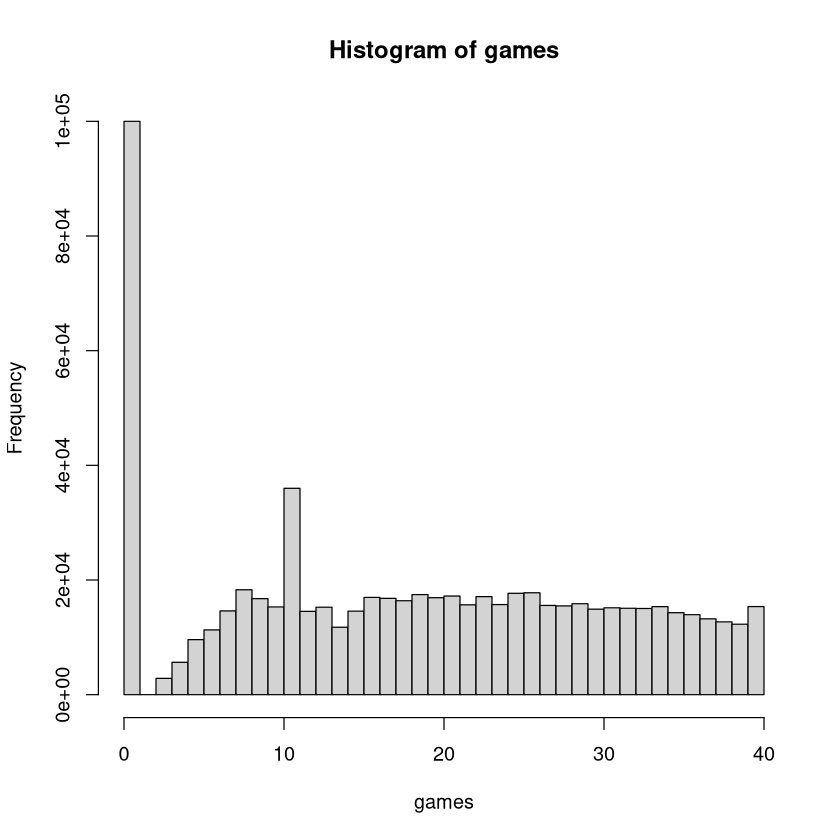

In [124]:
hist(games,0:40)
sort(table(games)/100000)

In [ ]:
#write.table(table(games),file="firstlap_hist.txt")

In [71]:
c(1,2,1) %*% t(c(2,3,4))

2,3,4
4,6,8
2,3,4


In [258]:
as.list(c(1,2,3))

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] 3

In [57]:
a = data.frame(
    nm = c("Hey!","There","Hey!"),
    nums = c(1,2,3)
)

In [425]:
# Data Analysis

In [30]:
freqdat = games2
freqdat_avg = lapply(freqdat,f<-function(x){x/1000})

In [31]:
freqmat = matrix(0,100,40)

for (sq in 1:40){
    for (deprec in 1:100){
        freqmat[deprec,sq] = as.numeric(freqdat_avg[[deprec]][as.character(sq)])
    }
}

freqmat[1,1] = freqmat[1,1] - 1
freqmat = cbind(1:100,freqmat)

In [32]:
freqdf = as.data.frame(freqmat)

In [33]:
cnames = c()
for (n in 1:40){
    cnames = append(cnames,paste("Square",as.character(n),sep=""))
}

In [34]:
colnames(freqdf)[2:41] = cnames
colnames(freqdf)[1] = "Turn"

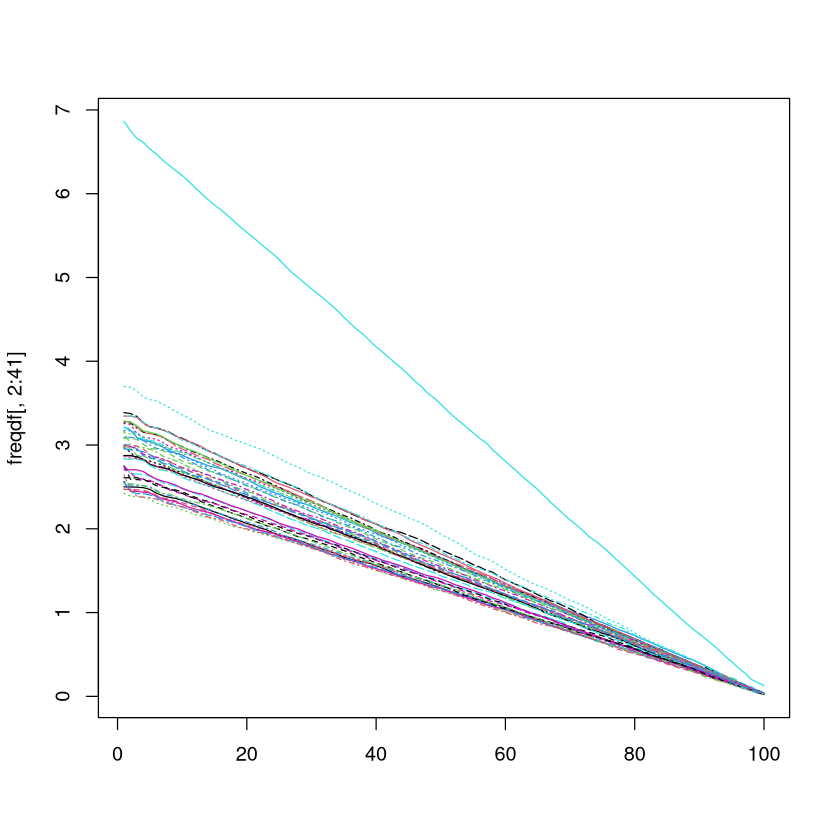

In [35]:
matplot(freqdf[,2:41],type="l")

In [36]:
depreciation = c()
for (sq in 1:40){
    depreciation = append(depreciation,coef(lm(eval(parse(text=paste("Square",as.character(sq)," ~ Turn",sep=""))),data=freqdf))[[2]])
}

In [37]:
names(depreciation) = cnames
#write.table(depreciation,file="deprec.txt")